In [24]:
import os
import awswrangler as wr
import pandas as pd
import numpy as np
import tempfile
import joblib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.metrics import mean_absolute_error, classification_report

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: "{:.5f}".format(x))

In [3]:
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'
seed = 42

In [25]:
# AWS directories
s3_root = 's3://crc-data-lake-research/sma/jimmy_woo/'
database = 'crc_data_lake_research'
results_path = '{}temp_resuts'.format(s3_root)

In [5]:
query = """
SELECT *
FROM crc_data_lake_research.sma_market_share_tier_4
"""

market_df = wr.athena.read_sql_query(
    query,
    database=database,
    s3_output=results_path,
    keep_files=False
)

In [6]:
query = """
SELECT *
FROM crc_data_lake_research.sma_ryan_fabek_tutela_population_per_tier
"""

pop_df =  wr.athena.read_sql_query(
    query,
    database=database,
    s3_output=results_path,
    keep_files=False
)

pop_tier_4 = pop_df[pop_df['tier'].str[0] == '4']

In [7]:
query = """
SELECT *
FROM crc_data_lake_research.sma_ryan_fabek_tutela_tower_density_per_tier_4
"""

tower_df =  wr.athena.read_sql_query(
    query,
    database=database,
    s3_output=results_path,
    keep_files=False
)

tower_df.rename(columns={'service': 'band'}, inplace=True)

In [8]:
# join all data frames
df = market_df.merge(pop_tier_4, left_on='tier_4', right_on='tier').drop(['tier'], axis=1)
df = df.merge(tower_df, on=['tier_4', 'band', 'block'])

cols = ['tier_4', 'service_provider', 'band', 'block', 'population', 'market_share', 'tx_density', 'num_data_pts']
df = df[cols]

In [9]:
sns.set_style('whitegrid')

plot_df = df[[cols[-1]]]
plot_df.loc[:, 'num_data_pts'] = plot_df['num_data_pts'].astype(int)
y = plot_df['num_data_pts'].to_numpy()

# distribution of number of data points
sns.violinplot(x=plot_df['num_data_pts']);

print('labels\nmean: {:.0f} median: {:.0f} max: {}'.format(np.mean(y), np.median(y), np.max(y)))

labels
mean: 149827 median: 187 max: 36353030


In [7]:
from pycaret.regression import *

In [25]:
# split data for holdout test
df_train, df_test = train_test_split(df, test_size=0.15, random_state=seed)
encoder = ce.TargetEncoder(cols=['tier_4', 'service_provider', 'band', 'block'], return_df=True)
custom_pp = [("target_encoder", encoder)]

s = setup(df_train, 
          target='num_data_pts',
          train_size=0.7/0.85,
          normalize=True,
          normalize_method='minmax', 
          preprocess=False,
          custom_pipeline=custom_pp,
          fold=5,
          fold_shuffle=True)

In [26]:
model = compare_models()

In [28]:
# evaluate on test set
pred = predict_model(model, data=df_test)

In [9]:
# save trained model
with tempfile.TemporaryFile() as fp:
    joblib.dump(model, fp)
    fp.seek(0)
    wr.s3.upload(local_file=fp, path=s3_root + 'saved_models/tier_regression.pkl')

In [11]:
from pycaret.classification import *

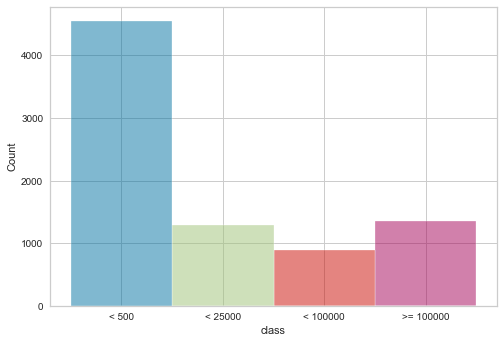

In [33]:
# assign classes
df['class'] = ''
df.loc[df['num_data_pts'] < 500, 'class'] = '0'
df.loc[(df['num_data_pts'] >= 500) & (df['num_data_pts'] < 25000), 'class'] = '1'
df.loc[(df['num_data_pts'] >= 25000) & (df['num_data_pts'] < 100000), 'class'] = '2'
df.loc[df['num_data_pts'] >= 100000, 'class'] = '3'

# observe at class distribution
f = sns.histplot(data=df.sort_values(by='class'), x='class', hue='class', legend=False);
f.xaxis.set_ticks([0, 1, 2, 3])
f.set_xticklabels(['< 500', '< 25000', '< 100000','>= 100000']);
plt.show()

df['class'] = pd.to_numeric(df['class'])
df = df.drop(columns=['num_data_pts'])

In [36]:
# split data for holdout test
df_train, df_test = train_test_split(df, test_size=0.15, random_state=seed)

s = setup(df_train, 
          target='class',
          train_size=0.7/0.85,
          normalize=True,
          normalize_method='minmax', 
          preprocess=False,
          custom_pipeline=custom_pp,
          fold=5,
          fold_shuffle=True)

In [37]:
model = compare_models()

In [39]:
# evaluate on test set
pred = predict_model(model, data=df_test)

In [46]:
print(classification_report(df_test['class'].astype('int'), pred['Label']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       683
           1       0.93      0.91      0.92       190
           2       0.84      0.85      0.85       142
           3       0.94      0.94      0.94       201

    accuracy                           0.95      1216
   macro avg       0.92      0.92      0.92      1216
weighted avg       0.95      0.95      0.95      1216



In [14]:
with tempfile.TemporaryFile() as fp:
    joblib.dump(model, fp)
    fp.seek(0)
    wr.s3.upload(local_file=fp, path=s3_root + 'saved_models/tier_classification.pkl')

In [27]:
## example code for model evaluation

# load model
#model = load_model('tier_classification', platform='aws', authentication={'bucket': 'crc-data-lake-research', 'path': 'sma/jimmy_woo/saved_models/'})


def tier_predict(tier, service_provider, band, block):
    row = df[(df['tier_4'] == tier) & (df['service_provider'] == service_provider) &
             (df['band'] == band) & (df['block'] == block)][['population', 'market_share', 'tx_density']].T.values

    population, market_share, tx_density = row
    
    # construct observation
    obs = pd.DataFrame.from_dict({'tier_4': tier,
                                  'service_provider': service_provider,
                                  'band': band,
                                  'block': block,
                                  'population': population[0],
                                  'market_share': market_share[0],
                                  'tx_density': tx_density[0]}, orient='index').T

    # apply transformations here
    obs = model['target_encoder'].transform(obs).astype('float')
    
    return model['trained_model'].predict(obs)